<a href="https://colab.research.google.com/github/usher233/GraduationThesis/blob/step2-model-construction/Codev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import keras
import tensorflow as tf

from keras.utils import normalize


In [2]:
!pip install segmentation_models
import segmentation_models as sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 4.5 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


In [3]:
TRAIN_DATA_DIR = "/content/drive/MyDrive/Graduation_thesis/Dataset/images"
IMG_SIZE = 128


In [4]:
#img_test = cv2.imread("/content/drive/MyDrive/Graduation_thesis/Dataset/mask/id_1.png")
#img_test = cv2.resize(img_test,(IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_NEAREST)
#img_test = np.array(img_test)

In [5]:
#check RGB values
#np.unique(img_test)

In [6]:
train_images = []
image_names = glob.glob("/content/drive/MyDrive/Graduation_thesis/Dataset/images/*.png")
image_names.sort()  #Make sure the loaded images are in order
#print(image_names)
for image in image_names:
  img = cv2.imread(image, 1)
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)   #resize the images to IMG_SIZE
  #print(image)
  train_images.append(img)
train_images = np.array(train_images)

In [7]:
train_images.shape

(640, 128, 128, 3)

In [8]:
train_masks = []
mask_names = glob.glob("/content/drive/MyDrive/Graduation_thesis/Dataset/mask/*.png")
mask_names.sort()
#print(mask_names)
for mask in mask_names:
  masks = cv2.imread(mask,1)
  masks = cv2.resize(masks,(IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_NEAREST)
  masks = cv2.cvtColor(masks, cv2.COLOR_RGB2BGR)
  #print(mask)
  train_masks.append(masks)
train_masks = np.array(train_masks)

In [9]:
train_masks.shape

(640, 128, 128, 3)

In [10]:
np.unique(train_masks[0])

array([  0, 127, 128, 255], dtype=uint8)

In [11]:
#mask labels
Background = [127,255,255]
Wheat = [128,0,0]
Soil = [0, 0, 0]

In [12]:
print(Background,Wheat,Soil)

[127, 255, 255] [128, 0, 0] [0, 0, 0]


In [13]:
def rgb_to_2D_label(label):
    """
    Supply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Background,axis=-1)] = 0
    label_seg [np.all(label==Wheat,axis=-1)] = 1  #actually soil
    label_seg [np.all(label==Soil,axis=-1)] = 2 #actually wheat
    
    label_seg = label_seg[:,:,1]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(train_masks.shape[0]):
    label = rgb_to_2D_label(train_masks[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2]


In [14]:
print(np.count_nonzero(labels[0] == 0))
print(np.count_nonzero(labels[0] == 1))
print(np.count_nonzero(labels[0] == 2))

5273
8904
2207


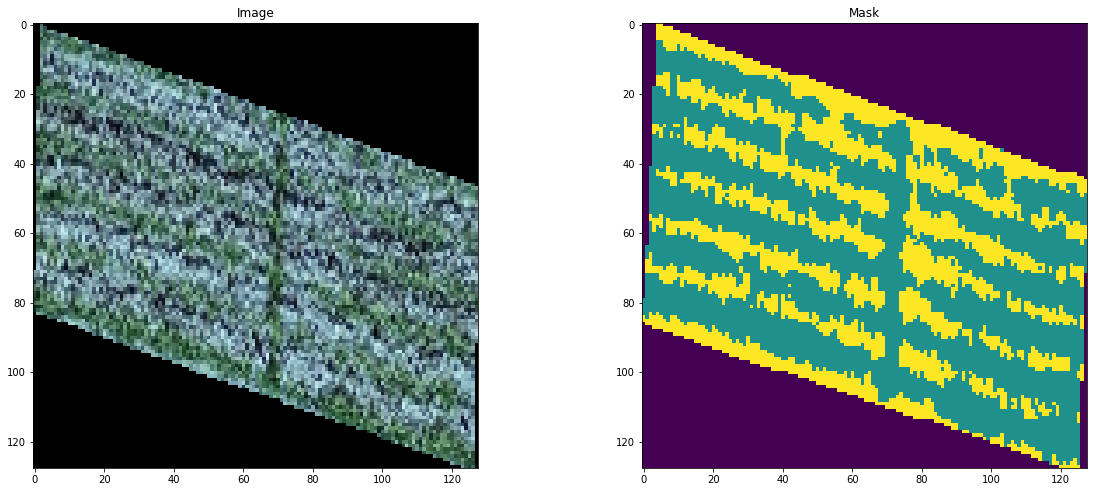

In [15]:
#check the dataset is right!!!!!!!
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[257]
mask = labels[257][:,:,0]
plt.figure(figsize=(20, 18))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask)
plt.show()

In [16]:
X = train_images
Y = labels
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42)

In [18]:
np.unique(y_train)

array([0., 1., 2.], dtype=float32)

In [19]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=3)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 3))



test_masks_cat = to_categorical(y_val, num_classes=3)
y_val_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 3))


In [20]:
y_val_cat.shape

(160, 128, 128, 3)

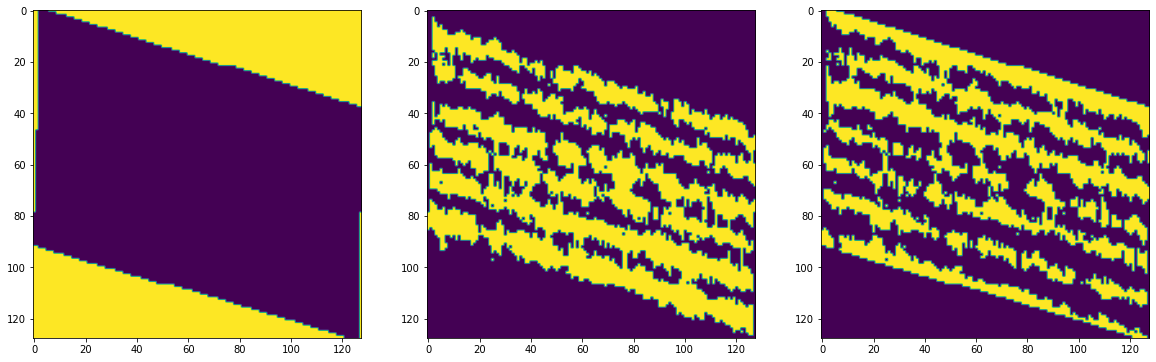

In [21]:
plt.figure(figsize=(20, 18))
plt.subplot(131)
plt.imshow(y_val_cat[0][:,:,0])#background-part
plt.subplot(132)
plt.imshow(y_val_cat[0][:,:,1])
plt.subplot(133)
plt.imshow(y_val_cat[0][:,:,2])
plt.show()

In [22]:
import segmentation_models as sm
BACKBONE = 'resnet34'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 40
n_classes = 3
activation = 'softmax'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [23]:
#preprocess input
x_train1 = preprocess_input(x_train)
x_val1 = preprocess_input(x_val)

In [24]:
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

85521592/85521592 [==============================] - 7s 0us/step


In [25]:
optim = keras.optimizers.Adam(LR)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.2, 0.4, 0.4])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)

In [26]:
history=model.fit( x_train1,
          y_train_cat,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(x_val1,y_val_cat))
model.save("resnet34_backbone_50epochs.hdf5")

Epoch 1/50
60/60 [==============================] - 20s 87ms/step - loss: 0.8511 - iou_score: 0.4822 - f1-score: 0.5899 - val_loss: 0.8637 - val_iou_score: 0.4320 - val_f1-score: 0.5464
Epoch 2/50
60/60 [==============================] - 4s 65ms/step - loss: 0.7905 - iou_score: 0.6803 - f1-score: 0.7884 - val_loss: 0.8224 - val_iou_score: 0.5973 - val_f1-score: 0.6957
Epoch 3/50
60/60 [==============================] - 4s 70ms/step - loss: 0.7688 - iou_score: 0.7305 - f1-score: 0.8316 - val_loss: 0.8055 - val_iou_score: 0.6336 - val_f1-score: 0.7340
Epoch 4/50
60/60 [==============================] - 4s 68ms/step - loss: 0.7577 - iou_score: 0.7531 - f1-score: 0.8487 - val_loss: 0.7885 - val_iou_score: 0.6709 - val_f1-score: 0.7708
Epoch 5/50
60/60 [==============================] - 4s 66ms/step - loss: 0.7519 - iou_score: 0.7647 - f1-score: 0.8572 - val_loss: 0.7814 - val_iou_score: 0.6911 - val_f1-score: 0.7913
Epoch 6/50
60/60 [==============================] - 4s 66ms/step - loss: 0

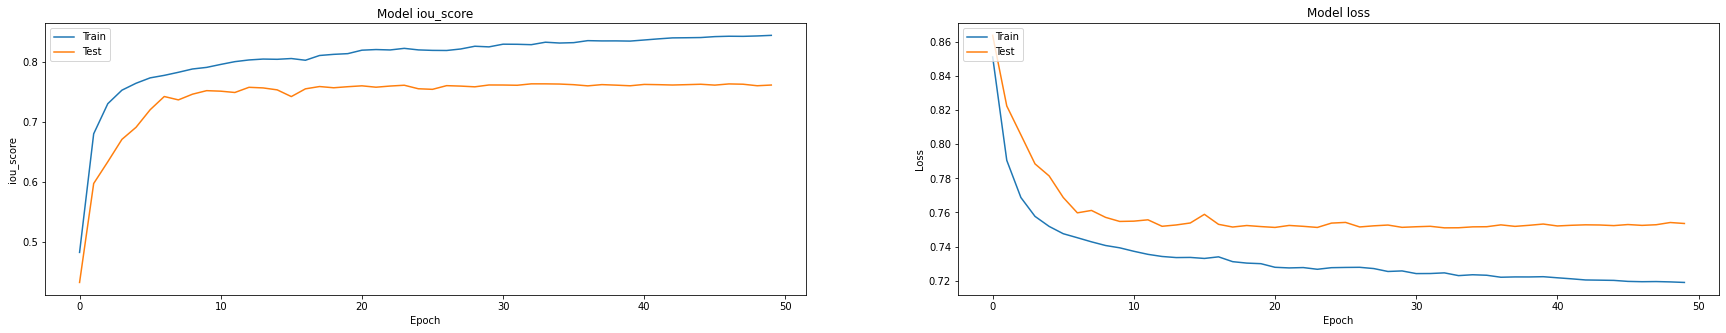

In [27]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 23ms/step


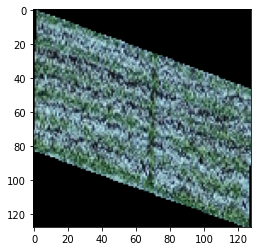

In [30]:
test_img = train_images[257]
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

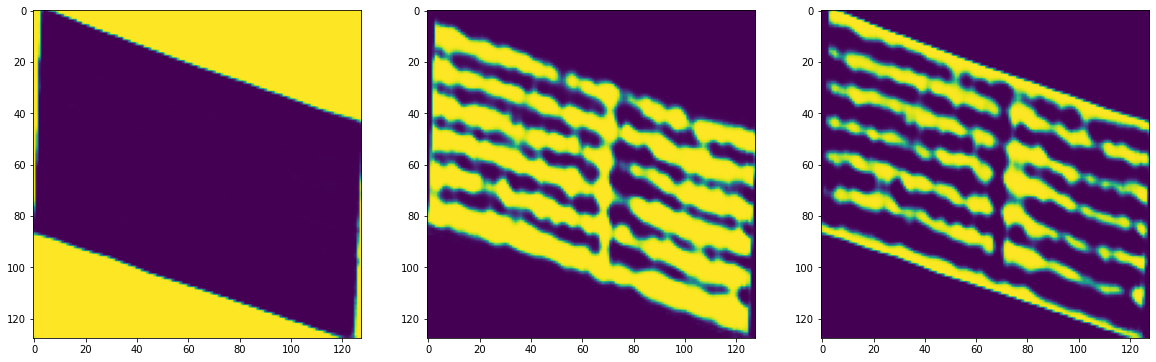

In [33]:
plt.figure(figsize=(20, 18))
plt.subplot(131)
plt.imshow(prediction[0][:,:,0])  #background-part
plt.subplot(132)
plt.imshow(prediction[0][:,:,1])  #wheat
plt.subplot(133)
plt.imshow(prediction[0][:,:,2])  #soil
plt.show()

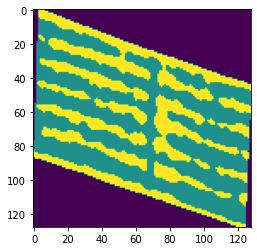

In [36]:
import keras
pred = np.argmax(prediction[0],axis=-1)
plt.imshow(pred)